In [1]:
import sys

sys.path.append('../')

from pharynx_analysis import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
from skimage.external import tifffile
import matplotlib.pyplot as plt

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 2000)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

C:\Users\javie\Anaconda3\envs\worm\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
meta_dir = Path("/Users/sean/code/wormAnalysis/data/paired_ratio")

In [4]:
all_mvmt = da.load_all_movement(meta_dir).pivot_table(columns='region', values=['movement'], index=['pair', 'experiment', 'animal']).reset_index()

In [5]:
# # LOAD ALL IMAGES
# imaging_scheme = "TL/470/410/470/410"
# all_rot_seg = []
# all_rot_fl  = []
# for exp_dir in meta_dir.iterdir():
#     if exp_dir.is_dir() and 'SKIP' not in exp_dir.stem:
#         ex = experiment.PairExperiment(exp_dir, imaging_scheme)
#         ex.load_images()
#         ex.seg_images = ex.segment_pharynxes()
#         ex.align_and_center()
#         all_rot_seg.append(ex.rot_seg)
#         all_rot_fl.append(ex.rot_fl)

# all_rot_seg = xr.concat(all_rot_seg.astype(np.uint8), dim='strain')
# all_rot_fl  = xr.concat(all_rot_fl, dim='strain')

# all_rot_seg.to_netcdf('/Users/sean/code/wormAnalysis/data/paired_ratio/all_rot_seg.nc')
# all_rot_fl.astype(np.int16).to_netcdf('/Users/sean/code/wormAnalysis/data/paired_ratio/all_rot_fl.nc')

all_rot_seg = xr.load_dataarray('/Users/sean/code/wormAnalysis/data/paired_ratio/all_rot_seg.nc')
all_rot_fl = xr.load_dataarray('/Users/sean/code/wormAnalysis/data/paired_ratio/all_rot_fl.nc')

In [6]:
def generate_shifted_ratios(rot_fl_stack, dx_range=(-.5, .5), dy_range=(-.2, .2), n_dx=4, n_dy=4):
    dxs = np.linspace(*dx_range,n_dx)
    dys = np.linspace(*dy_range,n_dy)
    vecs = np.array(np.meshgrid(dxs,dys)).T.reshape(-1,2)
    
    
    
    rs = []
    for i in tqdm_notebook(range(rot_fl_stack.strain.size)):
        i410 = rot_fl_stack.sel(wavelength='410', pair=0).isel(spec=i).values
        i470 = rot_fl_stack.sel(wavelength='470', pair=0).isel(spec=i).values
        for j in range(vecs.shape[0]):
            rs.append(i410 / ip.shift(i470, vecs[j]))
    return np.stack(rs, axis=0).astype(np.float32)

In [41]:
shifted_rs = generate_shifted_ratios(all_rot_fl, n_dx=3, n_dy=3)

In [42]:
tifffile.imsave('/Users/sean/code/wormAnalysis/data/paired_ratio/shifted_rs.tiff', shifted_rs)

(45, 120)

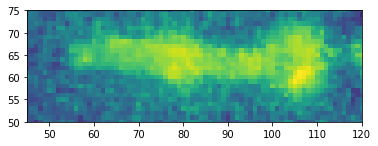

In [243]:
i = i + 1
i410 = all_rot_fl.sel(wavelength='410', pair=0).isel(spec=i).values
i470 = all_rot_fl.sel(wavelength='470', pair=0).isel(spec=i).values

plt.imshow(i410/i470)
plt.ylim([50,75])
plt.xlim([45,120])

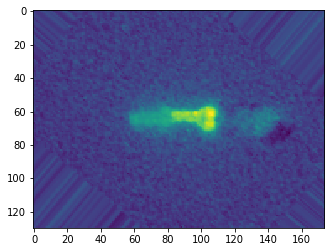

In [10]:
import elasticdeform

i410 = all_rot_fl.sel(wavelength='410', pair=0).isel(spec=0).values
i470 = all_rot_fl.sel(wavelength='470', pair=0).isel(spec=0).values

# apply deformation with a random 3 x 3 grid

deform_ = np.array([
    [[0,0,0,0,0,0]],
    [[0,0,0,0,0,0]],
])

i470_def = elasticdeform.deform_grid(i470, deform_, mode='nearest')

plt.imshow(i410/i470_def)

In [478]:
len(all_mvmt)

1726

In [475]:
all_rot_fl[]

<xarray.DataArray (strain: 1726, wavelength: 3, y: 130, x: 174)>
array([[[[5094, ..., 4975],
         ...,
         [5042, ..., 5157]],

        ...,

        [[ 290, ...,  297],
         ...,
         [ 294, ...,  289]]],


       ...,


       [[[   0, ...,    0],
         ...,
         [   0, ...,    0]],

        ...,

        [[ 288, ...,  272],
         ...,
         [ 282, ...,  290]]]], dtype=int16)
Coordinates:
  * wavelength  (wavelength) object 'TL' '470' '410'
  * strain      (strain) object 'HD233' 'HD233' 'HD233' ... 'HD233' 'HD233'
Dimensions without coordinates: y, x

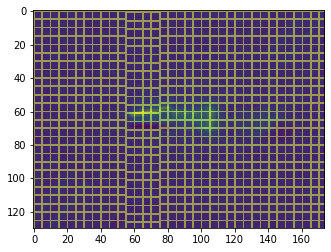

In [46]:
i = 0
X = np.zeros((130, 174))
X[:, ::5] = 1
X[::5, :] = 1

mag = .5
deform_pbulb = np.array([
    [[0,0,0,0,0,0,0,0,0]],
    [[0,0,0,0,0,-1,0,0,0]],
]) * mag

deform_abulb = np.array([
    [[0,0,0,-1,0,0,0,0,0]],
    [[0,0,0,0,0,0,0,0,0]],
])

i410 = all_rot_fl.sel(wavelength='410', pair=0).values[0]
i470 = all_rot_fl.sel(wavelength='470', pair=0).values[0]

X = elasticdeform.deform_grid(X, deform_abulb, mode='nearest', order=0)
i470_def = elasticdeform.deform_grid(i470, deform_abulb, mode='nearest', order=2)
r_moving_post_bulb = i410/i470_def
# tifffile.imsave('/Users/sean/code/wormAnalysis/data/paired_ratio/synthetic-SKIP/post_3_bulb.tiff', r_moving_post_bulb.astype(np.float32))
plt.imshow(r_moving_post_bulb)
plt.imshow(X, alpha=.5)
plt.gca().set_aspect('equal')

ims = []

for mag in np.hstack([np.linspace(0,1,10), np.linspace(1,0,10), np.linspace(0,-1,10), np.linspace(-1,0,10)]):
    deform_pbulb = np.array([
        [[0,0,0,0,0,0,0,0,0]],
        [[0,0,0,0,0,-1,0,0,0]],
    ]) * mag
    
    deform_abulb = np.array([
        [[0,0,0,-1,0,0,0,0,0]],
        [[0,0,0,0,0,0,0,0,0]],
    ]) * mag
    i470_def = elasticdeform.deform_grid(i470, deform_abulb, mode='nearest', order=2)
    r_moving_post_bulb = i410/i470_def
    ims.append(r_moving_post_bulb)

tifffile.imsave('/Users/sean/Desktop/moving_ant.tiff', np.stack(ims, axis=0).astype(np.float32))

In [39]:
np.hstack([np.linspace(0,1,10), np.linspace(1,0,10), np.linspace(0,-1,10), np.linspace(-1,0,10)])

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ,
        1.        ,  0.88888889,  0.77777778,  0.66666667,  0.55555556,
        0.44444444,  0.33333333,  0.22222222,  0.11111111,  0.        ,
        0.        , -0.11111111, -0.22222222, -0.33333333, -0.44444444,
       -0.55555556, -0.66666667, -0.77777778, -0.88888889, -1.        ,
       -1.        , -0.88888889, -0.77777778, -0.66666667, -0.55555556,
       -0.44444444, -0.33333333, -0.22222222, -0.11111111,  0.        ])

In [49]:
seg_dir = Path('/Users/sean/code/wormAnalysis/data/segmentation_training_data/')

In [61]:
imgs = []
for img_path in list(seg_dir.glob('**/**/*-seg.tif*')):
    imgs.append(tifffile.imread(str(img_path)))

In [64]:
sum([i.shape[0] for i in imgs])

8264